In [10]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import argparse
import cv2
import DenseNet_Architecture
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [11]:

train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")
test = pd.read_csv("sign_mnist_test.csv")
y = test['label']


y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']


In [12]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [13]:
x_train = train_df.values
x_test = test_df.values

In [14]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


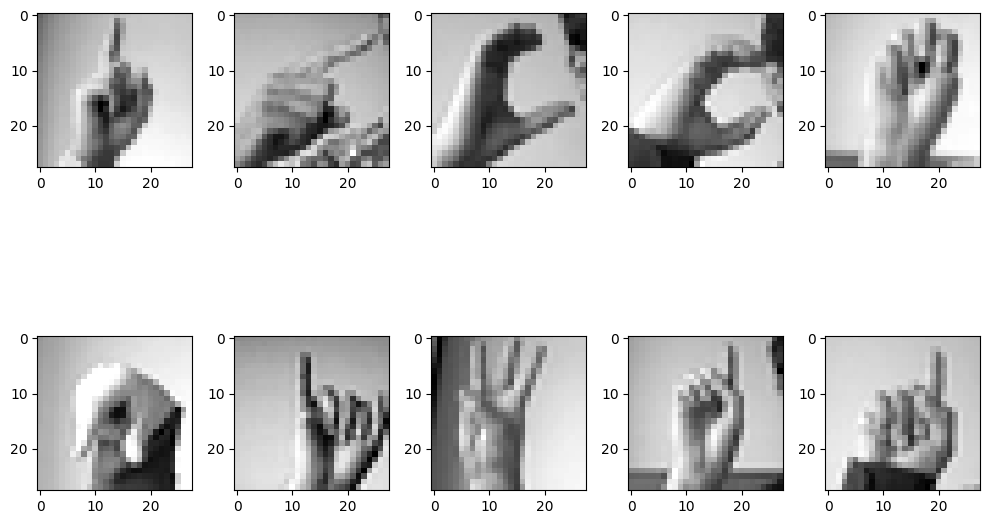

In [15]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(x_train[k].reshape(28, 28), cmap="gray")
        k += 1
    plt.tight_layout()


In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=10,
    zoom_range=0.1,  # Randomly zoom image
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


In [17]:
model = DenseNet_Architecture.DenseNet((28,28,1), 24)

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy', 'AUC'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 28, 28, 64)   640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 28, 28, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 64)  0           ['batch_normalization_34[0]

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("jupyter_model", "weights-{epoch:03d}.ckpt"),
    save_weights_only=True,
    verbose=1,
)
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=20,
                    validation_data=(x_test, y_test), callbacks=[cp_callback])


Epoch 1/20
215/215 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.8085 - auc: 0.9912
Epoch 1: saving model to jupyter_model\weights-001.ckpt
215/215 [==============================] - 598s 3s/step - loss: 0.6129 - accuracy: 0.8085 - auc: 0.9912 - val_loss: 11.9988 - val_accuracy: 0.0287 - val_auc: 0.5079
Epoch 2/20
215/215 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9854 - auc: 0.9998
Epoch 2: saving model to jupyter_model\weights-002.ckpt
215/215 [==============================] - 620s 3s/step - loss: 0.0524 - accuracy: 0.9854 - auc: 0.9998 - val_loss: 3.4270 - val_accuracy: 0.3454 - val_auc: 0.8063
Epoch 3/20
215/215 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9935 - auc: 0.9999
Epoch 3: saving model to jupyter_model\weights-003.ckpt
215/215 [==============================] - 676s 3s/step - loss: 0.0236 - accuracy: 0.9935 - auc: 0.9999 - val_loss: 0.3624 - val_accuracy: 0.8939 - val_auc: 0.9907
Epoch 4/2

In [ ]:


print("Accuracy of the model is - ",
      model.evaluate(x_test, y_test)[1]*100, "%")


In [ ]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16, 9)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
predictions = model.predict_classes(x_test)
cm = confusion_matrix(y, predictions)
cm = pd.DataFrame(cm, index=[i for i in range(25) if i != 9], columns=[
                  i for i in range(25) if i != 9])


In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')